# Baseline: Reflex Control

Steers the car using a PD controller on the estimated $y_m$ track median offset.

In [1]:
from DriveItMultiGym import *
from car import *
from sensors import *
from belief import *
import numpy as np
from numpy import pi

num_episodes = 1  # number of episodes to run
time_limit = 10.
gamma = 0.995
epsilon = 0.1
kp, kv = 30.0, 3.0
look_ahead = 0.1
speed_limit = 1.0

random_position=False

cars = [Car(Color.green, CarSpecifications(speed_limit))]
#cars = [Car(Color.green), \
#        Car(Color.orange, CarSpecifications(2.0)), \
#        Car(Color.purple, CarSpecifications(2.2))]

cars[0].add_dist_sensor(DistanceSensor.long_range(), 0.115, 0., 0.)
cars[0].add_dist_sensor(DistanceSensor.short_range(), 0.115, 0.02, pi / 6.)
cars[0].add_dist_sensor(DistanceSensor.short_range(), 0.115, -0.02, -pi / 6.)
cars[0].add_dist_sensor(DistanceSensor.short_range(), 0., 0.055, pi / 4.)
cars[0].add_dist_sensor(DistanceSensor.short_range(), 0., -0.055, -pi / 4.)
    
#cars[1].add_dist_sensor(DistanceSensor(1., 0.03, pi / 4, 0.01), 0.06, 0., 0)
#cars[2].add_dist_sensor(DistanceSensor(1., 0.03, pi / 4, 0.01), 0.06, 0., 0)

pos = [PositionTracking(car) for car in cars]
env = DriveItEnv(cars, time_limit, gamma, noisy=True)
observations = env._reset(random_position)
beliefs = PositionTracking.reset_all(pos, observations)
ym_ = {c: 0.0 for c in cars}
done = False
reward_episode = {c: 0.0 for c in cars}
reward_sum = {c: 0.0 for c in cars}
crashes = 0
actions = {}

carpos = []; obs = []; belpos = []; bel = []; err = []

for i_episode in range(1, num_episodes + 1):
    while not done:
        if num_episodes < 2 and time_limit < 60.0:
            env.render()

        for c, b in beliefs.items():
            xm, ym, thetam, v, K = b
            
            ym_dot = (ym - ym_[c]) / dt
            ym_[c] = ym
            f = K + kp * ym + kv * ym_dot
            if f > epsilon: action = 2
            elif f < -epsilon: action = 1
            else: action = 0

            for j in range(len(c.dist_sensors)):
                sensor = c.dist_sensors[j]
                d = sensor.read(cars)
                if d < 0.2 \
                or j == 0 and d < 0.5 and xm > loop_median_length:
                    action += 6
                    break
            
            if action < 6 and v < speed_limit:
                action += 3
                            
            actions[c] = action
        
        carpos.append(cars[0].get_position())
        #obs.append(observations[cars[0]])
        #belpos.append(pos[0].position)
        bel.append(beliefs[cars[0]])
        e = cars[0].get_position()[:-1] - pos[0].position[:-1]
        e2 = wrap(cars[0].get_position()[2] - beliefs[cars[0]][2], -pi, pi)
        err.append((e[0], e[1], e2))

        observations, rewards, done, info = env.step(actions)
        beliefs = PositionTracking.update_all(pos, observations, dt)
        for car in cars:
            reward_episode[car] += rewards[car]

    if num_episodes <= 10:
        print('Episode %d %s. reward: %f, laps: %f' % \
              (i_episode, info['done'], reward_episode[cars[0]], \
               reward_episode[cars[0]] / lap_median_length))

    if info['done'] != 'complete':
        crashes += 1

    for car in cars:
        reward_sum[car] += reward_episode[car]
        reward_episode[car] = 0
    observations = env._reset(random_position)
    beliefs = PositionTracking.reset_all(pos, observations)
    done = False

if num_episodes > 1:
    print('Average reward: %f with %d crashes' % \
          (reward_sum[cars[0]] / num_episodes, crashes))

Episode 1 complete. reward: 6.933333, laps: 1.377221


In [2]:
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use('ggplot')
%matplotlib inline
sns.set()

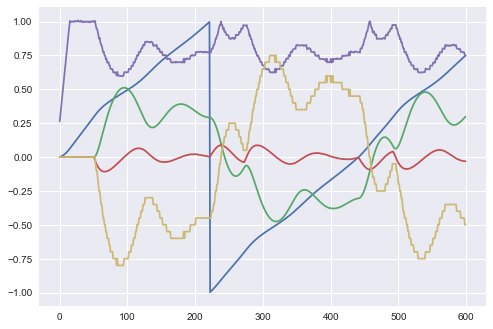

In [3]:
y = plt.plot([pos[0].normalize(b) for b in bel])

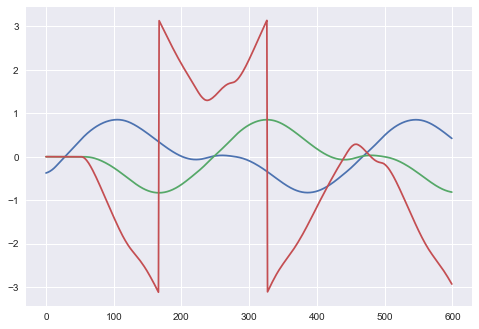

In [4]:
y = plt.plot(carpos)

In [3]:
from DriveItCircuit import *
coord = [median_to_cartesian(s[0],s[1],s[2]) for s in bel]
x = [c[0] for c in coord]
y = [c[1] for c in coord]

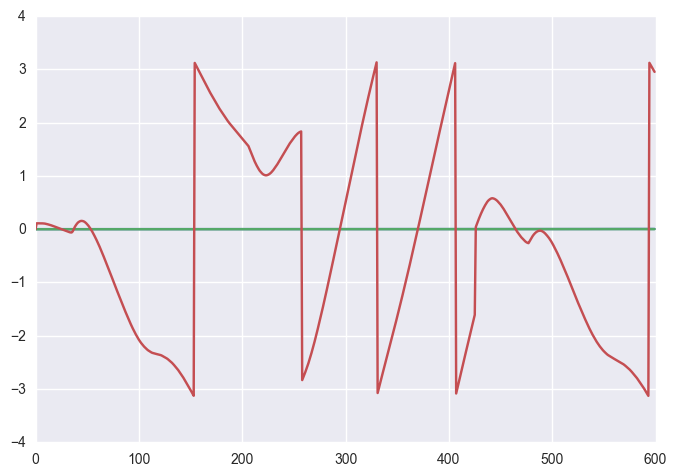

In [6]:
y = plt.plot([e for e in err])

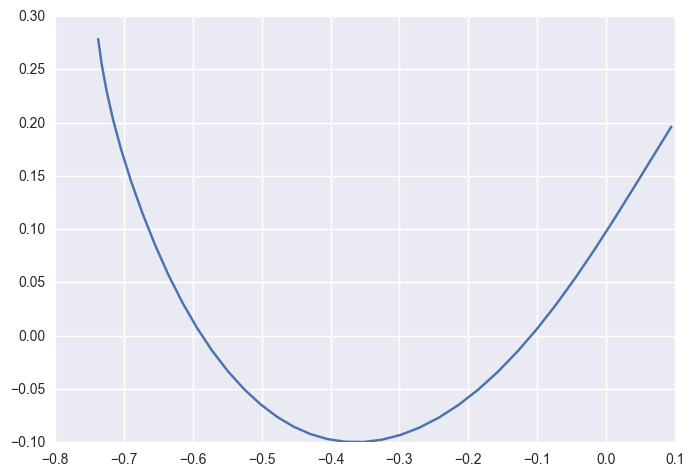

In [4]:
plt.plot(x, y)

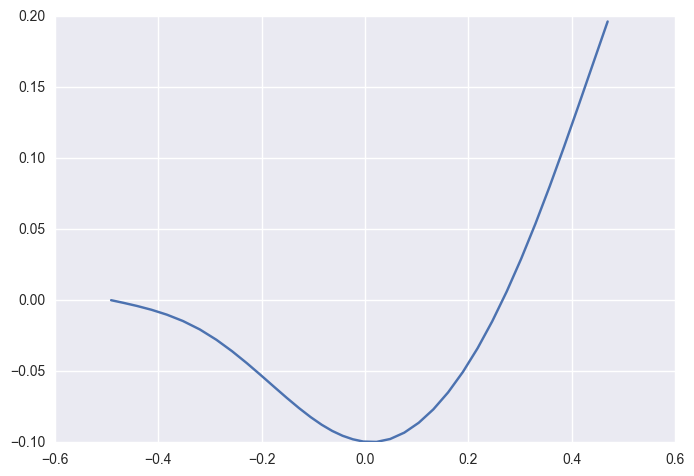

In [5]:
med = [(s[0],s[1]) for s in bel]
xm = [c[0] for c in med]
ym = [c[1] for c in med]
plt.plot(xm, ym)

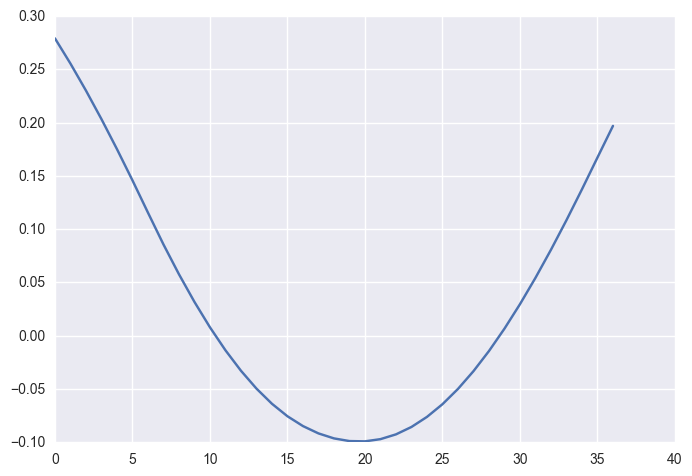

In [6]:
i = 1
y = plt.plot([p[i] for p in carpos])
y = plt.plot([p[i] for p in belpos])

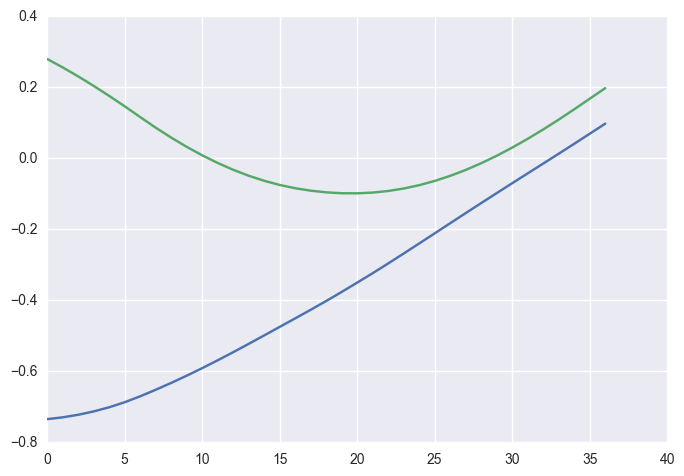

In [7]:
y = plt.plot([p[:-1] for p in carpos])

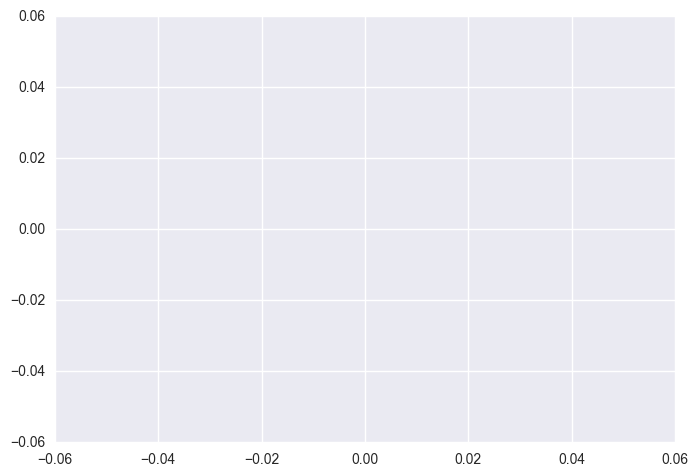

In [12]:
y = plt.plot([p[:-1] for p in belpos])

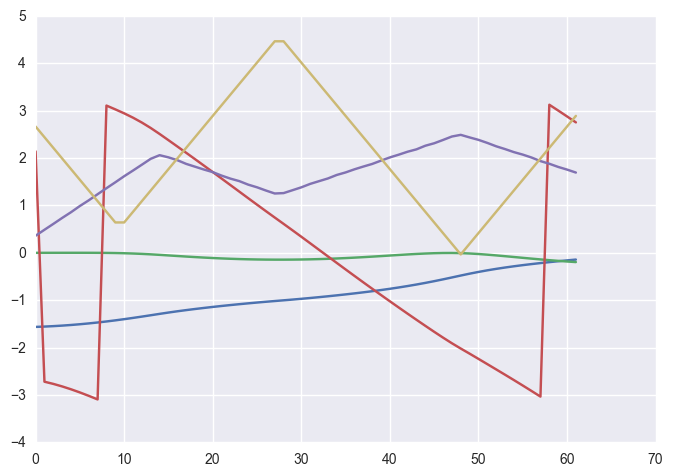

In [14]:
y = plt.plot([b for b in bel])

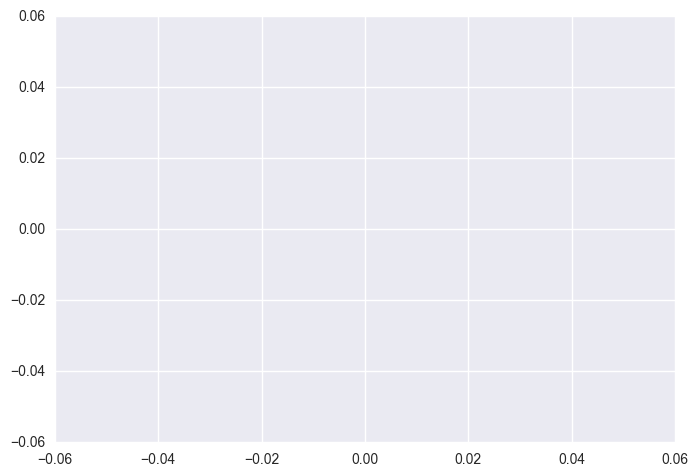

In [44]:
y = plt.plot([o for o in obs])

In [11]:
env._reset(random_position)

[array([-0.30159535,  0.        , -0.88246308,  0.        ,  2.21666667])]

In [12]:
env.render()

In [45]:
# out penalty = max discounted reward for median laps at full speed
2.5 * dt / (1 - gamma)

8.333333333333325

In [13]:
c = cars[0]
isinstance(c.front_left, Part)

True